## **MODELING**

This notebook implements machine learning models based on the comprehensive **EDA findings** and **preprocessing recommendations**.
We follow an **evidence-based approach** to ensure the modeling strategy aligns with the data characteristics and patterns identified earlier.

### **Modeling Strategy**

* **Model Selection** – Logistic Regression (baseline), Random Forest, and XGBoost (as recommended by EDA)
* **Hyperparameter Tuning** – `StratifiedKFold` cross-validation optimizing for **Macro F1-score**
* **Class Imbalance Handling** – Balanced class weights and **stratified sampling** during training
* **Feature Importance** – Validate high-signal and engineered features identified in EDA
* **Model Evaluation** – Confusion matrix, classification report, ROC-AUC, balanced accuracy, and macro F1
* **Explainability** – SHAP values and model coefficients for feature interpretation


### **EDA Evidence for Modeling**

| EDA Finding                 | Modeling Implication                                                                    |
| --------------------------- | --------------------------------------------------------------------------------------- |
| **Non-linear interactions** | Use tree-based models (Random Forest, XGBoost) to capture complex feature relationships |
| **Class imbalance**         | Apply stratified sampling and evaluate with balanced metrics                            |
| **Feature engineering**     | Validate derived variables such as `Total_Income`, `Loan_to_Income`, and `EMI`          |
| **Outlier impact**          | Use `RobustScaler` and IQR-based clipping; ensemble models are more robust              |
| **Production focus**        | Select interpretable and stable models suitable for deployment and policy insights      |

#### **1. Import Libraries and Load Preprocessed Data**


In [1]:
# core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,balanced_accuracy_score, accuracy_score,f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import joblib
import pickle

# advanced ML libraries
try: 
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost is not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTBM_AVAILABLE = True
except ImportError:
    LIGHTBM_AVAILABLE = False
    print("LightGBM is not available. Install with: pip install lightgbm")
    
# explainability 
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP is not available. Install with: pip install shap")

# set style for better visualizations
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("All libraries imported successfully.") 
print(f"XGBoost available: {XGBOOST_AVAILABLE}, LightGBM available: {LIGHTBM_AVAILABLE}, SHAP available: {SHAP_AVAILABLE}")
      


SHAP is not available. Install with: pip install shap
All libraries imported successfully.
XGBoost available: True, LightGBM available: True, SHAP available: False


In [2]:
# Load preprocessed data
print("LOADING PREPROCESSED DATA")

try:
    # Load scaled feature datasets
    X_train = pd.read_csv("X_train_scaled.csv")
    X_test = pd.read_csv("X_test_scaled.csv")
    
    # Load target variables
    y_train = pd.read_csv("y_train.csv").squeeze()
    y_test = pd.read_csv("y_test.csv").squeeze()
    
    # Load preprocessing objects
    scaler = joblib.load("robust_scaler.pkl")
    selected_features = joblib.load("selected_features.pkl")
    
    print("Preprocessed data loaded successfully.\n")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Display class distribution
    print("\nClass Distribution:")
    print("Training set:")
    print(y_train.value_counts().sort_index())
    print("\nTest set:")
    print(y_test.value_counts().sort_index())
    
    # Display selected features
    print(f"\nSelected Features ({len(selected_features)}):")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i:2d}. {feature}")
        
except FileNotFoundError as e:
    print(f"Error loading preprocessed data: {e}")
    print("\nPlease run the preprocessing notebook first to generate the required files.")
    print("Required files:")
    print(" - X_train_scaled.csv, X_test_scaled.csv")
    print(" - y_train.csv, y_test.csv")
    print(" - robust_scaler.pkl, selected_features.pkl")


LOADING PREPROCESSED DATA
Preprocessed data loaded successfully.

Training set: (27228, 18)
Test set: (6808, 18)

Class Distribution:
Training set:
case_status
0    13597
1    13631
Name: count, dtype: int64

Test set:
case_status
0    3421
1    3387
Name: count, dtype: int64

Selected Features (17):
 1. continent
 2. education_of_employee
 3. has_job_experience
 4. requires_job_training
 5. no_of_employees
 6. yr_of_estab
 7. region_of_employment
 8. full_time_position
 9. need_training_has_exp
10. need_training_no_exp
11. region_median_wage
12. annual_wage_log
13. wage_per_hour_log
14. wage_per_week_log
15. wage_per_month_log
16. age_of_estab_log
17. wage_vs_region_log


#### **2. Baseline Model - Logistic Regression**


In [3]:
# Baseline Logistic Regression model
print("BASELINE LOGISTIC REGRESSION MODEL")
print("EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction")

# Create and train baseline model
baseline_model = LogisticRegression(
    random_state=234,
    max_iter=1000
    # class_weight='balanced'  # Handle class imbalance as recommended by EDA
)

# Train the model
baseline_model.fit(X_train, y_train)

# Make predictions
y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred, average='binary')
test_f1 = f1_score(y_test, y_test_pred, average='binary')

print(f"\nBaseline Model Performance:")
print(f"Training - Accuracy: {train_accuracy:.3f}, Balanced Acc: {train_balanced_acc:.3f}, Binary F1: {train_f1:.3f}")
print(f"Test - Accuracy: {test_accuracy:.3f}, Balanced Acc: {test_balanced_acc:.3f}, Binary F1: {test_f1:.3f}")

# Display feature coefficients (interpretability)
print(f"\nFeature Coefficients (Top 10):")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': baseline_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['coefficient']:.3f}")

# Store baseline results
baseline_results = {
    'model': 'Logistic Regression',
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_acc': train_balanced_acc,
    'test_balanced_acc': test_balanced_acc,
    'train_f1': train_f1,
    'test_f1': test_f1
}

print(".... Baseline model completed!")


BASELINE LOGISTIC REGRESSION MODEL
EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction

Baseline Model Performance:
Training - Accuracy: 0.726, Balanced Acc: 0.726, Binary F1: 0.726
Test - Accuracy: 0.730, Balanced Acc: 0.730, Binary F1: 0.730

Feature Coefficients (Top 10):
 1. has_job_experience: -1.514
 2. education_of_employee: -1.091
 3. region_median_wage: -0.741
 4. requires_job_training: -0.599
 5. need_training_no_exp: -0.599
 6. region_of_employment: -0.382
 7. full_time_position: -0.368
 8. wage_vs_region_log: 0.142
 9. need_training_has_exp: -0.087
10. age_of_estab_log: 0.077
.... Baseline model completed!


### **3. Random Forest Classifier (EDA Recommendation)**

Random Forest Classifier
EDA Recommendation: RObust, captures interactions, insensitive to scaling and moderate outliers

Random Forest Performance
Training Accuracy: 1.000, Balanced Acc: 1.000, Macro F1: 1.000
Test Accuracy: 0.764, Balanced Acc: 0.764, Macro F1: 0.764

 Feature Importance (Top 10)
1.000000. education_of_employee: 0.226
2.000000. no_of_employees: 0.083
3.000000. has_job_experience: 0.080
4.000000. Unnamed: 0: 0.078
5.000000. wage_vs_region_log: 0.074
6.000000. age_of_estab_log: 0.063
7.000000. wage_per_month_log: 0.063
8.000000. wage_per_hour_log: 0.062
9.000000. annual_wage_log: 0.061
10.000000. wage_per_week_log: 0.061


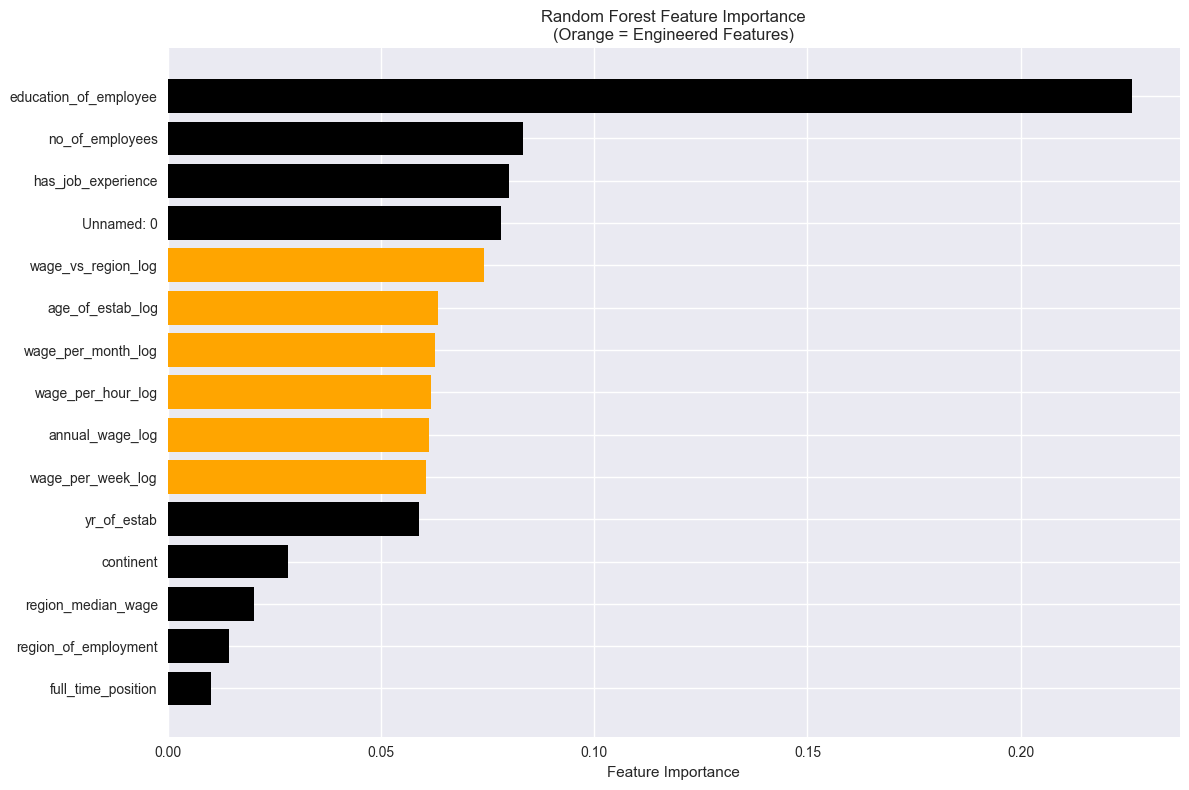

...Random Forest model completed...


In [4]:
# Random Forest classifier
print("Random Forest Classifier")
print("EDA Recommendation: RObust, captures interactions, insensitive to scaling and moderate outliers")

# create Random Forest model
rf_model = RandomForestClassifier(
    n_estimators = 100,
    random_state = 42,
    class_weight = "balanced", # handle class imbalance
    n_jobs = -1 # use all available cores
)


# train the model
rf_model.fit(X_train, y_train)

# make prediction
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# calculate metrics
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

train_balanced_acc_rf = balanced_accuracy_score(y_train, y_train_pred_rf)
test_balanced_acc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)


train_f1_rf = f1_score(y_train, y_train_pred_rf, average = "macro")
test_f1_rf = f1_score(y_test, y_test_pred_rf, average = "macro")

print(f"\nRandom Forest Performance")
print(f"Training Accuracy: {train_accuracy_rf:.3f}, Balanced Acc: {train_balanced_acc_rf:.3f}, Macro F1: {train_f1_rf:.3f}")
print(f"Test Accuracy: {test_accuracy_rf:.3f}, Balanced Acc: {test_balanced_acc_rf:.3f}, Macro F1: {test_f1_rf:.3f}")

# feature importance analysis
print(f"\n Feature Importance (Top 10)")

feature_importance_rf = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)


for i, (_, row) in enumerate(feature_importance_rf.head(10).iterrows(), 1):
    print(f"{i:2f}. {row["feature"]}: {row["importance"]:.3f}")
    
#visualize feature importance
plt.figure(figsize = (12,8))
top_features_rf = feature_importance_rf.head(15) 


colors = ["orange" if any(keyword in f.lower() for keyword in ["total", "log","year"]) else "black" for f in top_features_rf["feature"]]

plt.barh(range(len(top_features_rf)), top_features_rf["importance"], color = colors)
plt.yticks(range(len(top_features_rf)),top_features_rf["feature"])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance\n(Orange = Engineered Features)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# store random forest result
rf_results = {
    "model": "Random Forest",
    "train_accuracy":train_accuracy_rf,
    "test_accuracy": test_accuracy_rf,
    "train_balanced_acc": train_balanced_acc_rf,
    "test_balanced_acc":test_balanced_acc_rf,
    "train_f1":train_f1_rf,
    "test_f1": test_f1_rf
    
    }

print("...Random Forest model completed...")

### **4. XGBoost Classifier (EDA Recommendation)**

In [5]:
#  XGBoost Classifier
print("EDA recommendation: Best performance for structured data, handles non-linearity and feature interactions automatically")

if XGBOOST_AVAILABLE:
    # Create XGBoost model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss',
        n_jobs=-1
    )
     # Train the model (using encoded labels for XGBoost)
    xgb_model.fit(X_train, y_train)
   # Make predictions
    y_train_pred_xgb = xgb_model.predict(X_train)
    y_test_pred_xgb = xgb_model.predict(X_test)   
    
     # Calculate metrics using original labels
    train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
    test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
    
    train_balanced_acc_xgb = balanced_accuracy_score(y_train, y_train_pred_xgb)
    test_balanced_acc_xgb = balanced_accuracy_score(y_test, y_test_pred_xgb)
    
    train_f1_xgb = f1_score(y_train, y_train_pred_xgb, average='macro')
    test_f1_xgb = f1_score(y_test, y_test_pred_xgb, average='macro')
    
    print(f"\nXGBoost Performance:")
    print(f"Training - Accuracy: {train_accuracy_xgb:.3f}, Balanced Acc: {train_balanced_acc_xgb:.3f}, Macro F1: {train_f1_xgb:.3f}")
    print(f"Test - Accuracy: {test_accuracy_xgb:.3f}, Balanced Acc: {test_balanced_acc_xgb:.3f}, Macro F1: {test_f1_xgb:.3f}")
    
    # Feature importance analysis
    print(f"\nFeature Importance (Top 10):")
    feature_importance_xgb = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    for i, (_, row) in enumerate(feature_importance_xgb.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']}: {row['importance']:.3f}")
    
    # Store XGBoost results
    xgb_results = {
        'model': 'XGBoost',
        'train_accuracy': train_accuracy_xgb,
        'test_accuracy': test_accuracy_xgb,
        'train_balanced_acc': train_balanced_acc_xgb,
        'test_balanced_acc': test_balanced_acc_xgb,
        'train_f1': train_f1_xgb,
        'test_f1': test_f1_xgb
    }
    
    print("XGBoost model completed!")
    
else:
    print("... XGBoost not available. Skipping XGBoost model.")
    xgb_results = None 

EDA recommendation: Best performance for structured data, handles non-linearity and feature interactions automatically

XGBoost Performance:
Training - Accuracy: 0.864, Balanced Acc: 0.864, Macro F1: 0.864
Test - Accuracy: 0.791, Balanced Acc: 0.791, Macro F1: 0.791

Feature Importance (Top 10):
 1. education_of_employee: 0.400
 2. has_job_experience: 0.213
 3. need_training_no_exp: 0.079
 4. region_median_wage: 0.055
 5. full_time_position: 0.044
 6. age_of_estab_log: 0.035
 7. continent: 0.031
 8. requires_job_training: 0.026
 9. yr_of_estab: 0.023
10. wage_vs_region_log: 0.022
XGBoost model completed!


#### **5. Model Comparison and Evaluation**


MODEL COMPARISON AND EVALUATION

Model Performance Comparison:
Model           Train Acc  Test Acc   Test F1   
Logistic Regression 0.726      0.730      0.730     
Random Forest   1.000      0.764      0.764     
XGBoost         0.864      0.791      0.791     

Best Model: XGBoost (Test F1: 0.791)


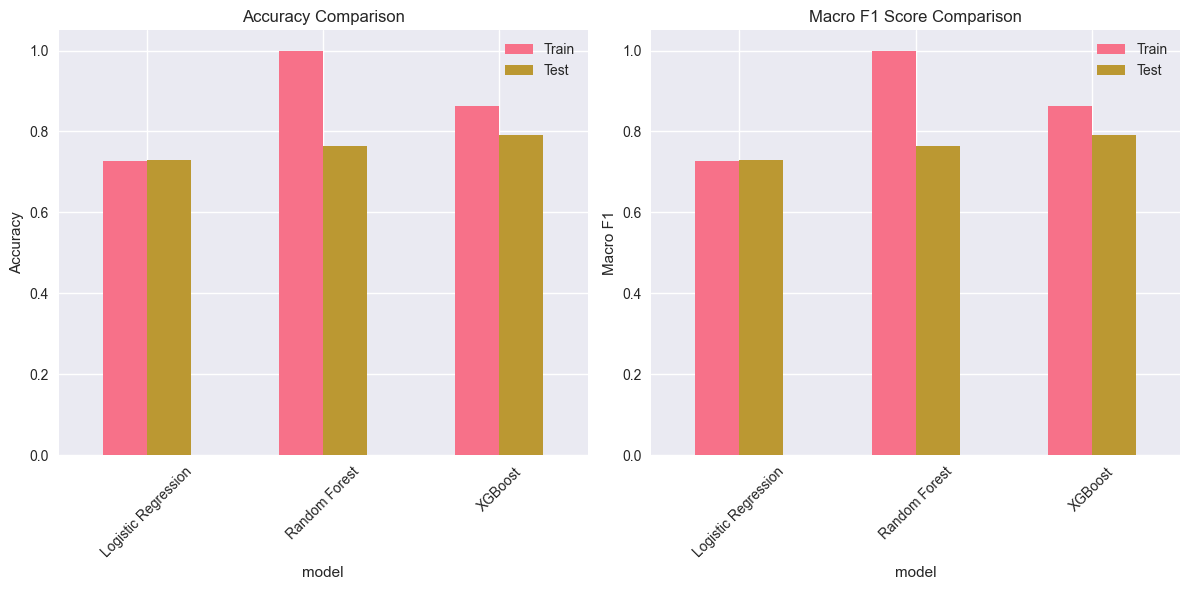

...Model comparison completed!


In [ ]:
print("MODEL COMPARISON AND EVALUATION")

# Collect all results
all_results = [baseline_results, rf_results]
if xgb_results is not None:
    all_results.append(xgb_results)

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.set_index('model')

print("\nModel Performance Comparison:")
print("=" * 80)
print(f"{'Model':<15} {'Train Acc':<10} {'Test Acc':<10} {'Test F1':<10}")
print("=" * 80)
for _, row in comparison_df.iterrows():
    print(f"{row.name:<15} {row['train_accuracy']:<10.3f} {row['test_accuracy']:<10.3f} {row['test_f1']:<10.3f}")

# Find best model based on test F1 score
best_model_name = comparison_df['test_f1'].idxmax()
best_model_score = comparison_df.loc[best_model_name, 'test_f1']

print(f"\nBest Model: {best_model_name} (Test F1: {best_model_score:.3f})")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # 3 Rows, 1 Column

# Accuracy comparison
# Note: Since 'axes' is 1D, we access plots via axes[0], axes[1], axes[2]
comparison_df[['train_accuracy', 'test_accuracy']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'])
axes[0].tick_params(axis='x', rotation=45)


# F1 Score comparison
comparison_df[['train_f1', 'test_f1']].plot(kind='bar', ax=axes[1])
axes[1].set_title('Macro F1 Score Comparison')
axes[1].set_ylabel('Macro F1')
axes[1].legend(['Train', 'Test'])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("...Model comparison completed!")

#### **6. Detailed Evaluation of Best Model**



DETAILED EVALUATION OF BEST MODEL
Best Model: XGBoost
Validation F1 Score: 0.791

Detailed Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.77      0.82      0.80      3421
           1       0.81      0.76      0.78      3387

    accuracy                           0.79      6808
   macro avg       0.79      0.79      0.79      6808
weighted avg       0.79      0.79      0.79      6808


Confusion Matrix for XGBoost:
[[2817  604]
 [ 818 2569]]


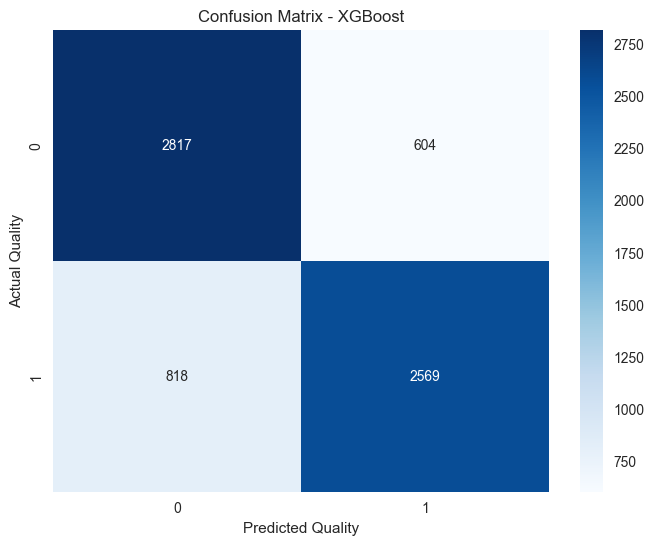


Per-class Performance for XGBoost:
Quality 0: 0.823 accuracy (3421 samples)
Quality 1: 0.758 accuracy (3387 samples)
...Detailed evaluation completed!


In [7]:
# Detailed evaluation of best model
print("DETAILED EVALUATION OF BEST MODEL")

# Get the best model
if best_model_name == 'Logistic Regression':
    best_model = baseline_model
    y_test_pred_best = y_test_pred
elif best_model_name == 'Random Forest':
    best_model = rf_model
    y_test_pred_best = y_test_pred_rf
elif best_model_name == 'XGBoost':
    best_model = xgb_model
    y_test_pred_best = y_test_pred_xgb

print(f"Best Model: {best_model_name}")
print(f"Validation F1 Score: {best_model_score:.3f}")

# Detailed classification report
print(f"\nDetailed Classification Report for {best_model_name}:")
print("=" * 60)
print(classification_report(y_test, y_test_pred_best))

# Confusion matrix
print(f"\nConfusion Matrix for {best_model_name}:")
cm = confusion_matrix(y_test, y_test_pred_best)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.show()

# Per-class performance
print(f"\nPer-class Performance for {best_model_name}:")
unique_classes = sorted(y_test.unique())
for class_label in unique_classes:
    class_mask = y_test == class_label
    if class_mask.sum() > 0:  # Only if class exists in test set
        class_accuracy = accuracy_score(y_test[class_mask], y_test_pred_best[class_mask])
        print(f"Quality {class_label}: {class_accuracy:.3f} accuracy ({class_mask.sum()} samples)")

print("...Detailed evaluation completed!")


### **7. Saving the model**

In [11]:
# Save best model and results
print("SAVING BEST MODEL AND RESULTS ")

# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print(f"- Best model ({best_model_name}) saved as 'best_model.pkl'")

# Save model comparison results
comparison_df.to_csv('model_comparison_results.csv')
print("- Model comparison results saved as 'model_comparison_results.csv'")

# Save detailed results
detailed_results = {
    'best_model': best_model_name,
    'best_model_score': best_model_score,
    'test_accuracy': comparison_df.loc[best_model_name, 'test_accuracy'],
    # 'test_balanced_acc': comparison_df.loc[best_model_name, 'test_balanced_acc'],
    'test_f1': comparison_df.loc[best_model_name, 'test_f1'],
    'confusion_matrix': cm.tolist(),
    'feature_importance': feature_importance_rf.to_dict('records') if best_model_name == 'Random Forest' else None
}

import json
with open('modeling_results.json', 'w') as f:
    json.dump(detailed_results, f, indent=2)
print("- Detailed results saved as 'modeling_results.json'")

# Save feature importance if available
if hasattr(best_model, 'feature_importances_'):
    feature_importance_best = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    feature_importance_best.to_csv('best_model_feature_importance.csv', index=False)
    print("- Best model feature importance saved as 'best_model_feature_importance.csv'")

print(f"\nMODELING SUMMARY")
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {comparison_df.loc[best_model_name, 'test_accuracy']:.3f}")
# print(f"Test Balanced Accuracy: {comparison_df.loc[best_model_name, 'test_balanced_acc']:.3f}")
print(f"Test Macro F1: {comparison_df.loc[best_model_name, 'test_f1']:.3f}")

print(f"\nFILES CREATED")
print("- best_model.pkl (trained model)")
print("- model_comparison_results.csv (performance comparison)")
print("- modeling_results.json (detailed results)")
if hasattr(best_model, 'feature_importances_'):
    print("- best_model_feature_importance.csv (feature importance)")

print(f"\nModeling phase completed successfully!")
print("... Ready for model deployment and production use")


SAVING BEST MODEL AND RESULTS 
- Best model (XGBoost) saved as 'best_model.pkl'
- Model comparison results saved as 'model_comparison_results.csv'
- Detailed results saved as 'modeling_results.json'
- Best model feature importance saved as 'best_model_feature_importance.csv'

MODELING SUMMARY
Best Model: XGBoost
Test Accuracy: 0.791
Test Macro F1: 0.791

FILES CREATED
- best_model.pkl (trained model)
- model_comparison_results.csv (performance comparison)
- modeling_results.json (detailed results)
- best_model_feature_importance.csv (feature importance)

Modeling phase completed successfully!
... Ready for model deployment and production use
